In [1]:
# Step 1: Import necessary libraries
import pandas as pd

# Step 2: Load the CSV file
file_path = 'dummy_saas_transactions.csv'  # Adjust the path if necessary
df = pd.read_csv(file_path)

# Step 3: Preview the dataset
print("Preview of the original transaction dataset:")
display(df.head())

# Step 4: Convert 'transaction_date' to datetime format
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Step 5: Check basic info
print("\nBasic information about the dataset:")
print(df.info())


Preview of the original transaction dataset:


,transaction_id,client_id,order_type,transaction_date,amount_usd
0,7,C00007,new_order,2023-01-01,120
1,5,C00005,new_order,2023-01-03,1080
2,3,C00003,new_order,2023-01-05,480
3,8,C00008,new_order,2023-01-07,240
4,2,C00002,new_order,2023-01-08,600



Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    284 non-null    int64         
 1   client_id         284 non-null    object        
 2   order_type        284 non-null    object        
 3   transaction_date  284 non-null    datetime64[ns]
 4   amount_usd        284 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ KB
None


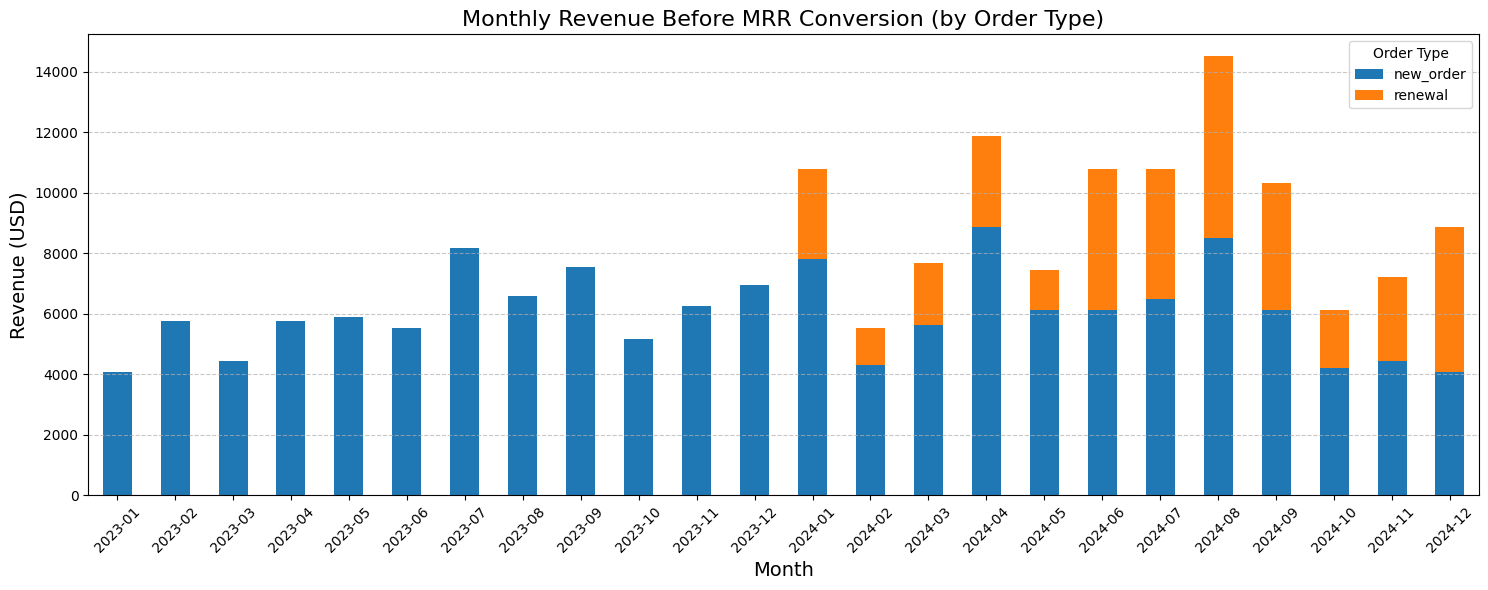

In [2]:
# Step 6: Create a new column 'year_month' for easy grouping
df['year_month'] = df['transaction_date'].dt.to_period('M')

# Step 7: Aggregate total amount by year_month and order_type
monthly_revenue = df.groupby(['year_month', 'order_type'])['amount_usd'].sum().unstack(fill_value=0)

# Step 8: Plotting
import matplotlib.pyplot as plt

# Convert year_month back to string for nicer x-axis labels
monthly_revenue.index = monthly_revenue.index.astype(str)

# Plot
monthly_revenue.plot(kind='bar', stacked=True, figsize=(15,6))
plt.title('Monthly Revenue Before MRR Conversion (by Order Type)', fontsize=16)
plt.ylabel('Revenue (USD)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Order Type')
plt.tight_layout()
plt.show()


In [3]:
# Step 9: Prepare to expand each transaction into 12 months of monthly MRR
expanded_records = []

# Step 10: Loop over each transaction
for idx, row in df.iterrows():
    start_date = row['transaction_date']
    monthly_mrr = row['amount_usd'] / 12  # Spread the annual amount over 12 months
    
    # Generate 12 monthly records
    for month_offset in range(12):
        active_month = (start_date + pd.DateOffset(months=month_offset)).to_period('M').to_timestamp()
        
        # Assign MRR type
        if row['order_type'] == 'new_order':
            if month_offset == 0:
                mrr_type = 'new_mrr'
            else:
                mrr_type = 'base_mrr'
        elif row['order_type'] == 'renewal':
            mrr_type = 'expansion_mrr'
        else:
            mrr_type = 'unknown'
        
        expanded_records.append({
            'client_id': row['client_id'],
            'transaction_id': row['transaction_id'],
            'order_type': row['order_type'],
            'active_month': active_month,
            'monthly_mrr': monthly_mrr,
            'mrr_type': mrr_type
        })

# Step 11: Create a new DataFrame
df_mrr = pd.DataFrame(expanded_records)

# Step 12: Preview
print("Preview of the expanded MRR dataset with refined MRR Types:")
display(df_mrr.head(5))


Preview of the expanded MRR dataset with refined MRR Types:


,client_id,transaction_id,order_type,active_month,monthly_mrr,mrr_type
0,C00007,7,new_order,2023-01-01,10.0,new_mrr
1,C00007,7,new_order,2023-02-01,10.0,base_mrr
2,C00007,7,new_order,2023-03-01,10.0,base_mrr
3,C00007,7,new_order,2023-04-01,10.0,base_mrr
4,C00007,7,new_order,2023-05-01,10.0,base_mrr


In [4]:
# Step 13: Group and summarize MRR by active_month and mrr_type

# First, ensure active_month is in the correct datetime format
df_mrr['active_month'] = pd.to_datetime(df_mrr['active_month'])

# Aggregate MRR
monthly_mrr_summary = df_mrr.groupby(['active_month', 'mrr_type'])['monthly_mrr'].sum().unstack(fill_value=0)

# Step 14: Preview the aggregated monthly MRR
print("Monthly MRR breakdown by MRR type:")
display(monthly_mrr_summary.head(5))


Monthly MRR breakdown by MRR type:


mrr_type,base_mrr,expansion_mrr,new_mrr
active_month,,,
2023-01-01,0.0,0.0,340.0
2023-02-01,340.0,0.0,480.0
2023-03-01,820.0,0.0,370.0
2023-04-01,1190.0,0.0,480.0
2023-05-01,1670.0,0.0,490.0


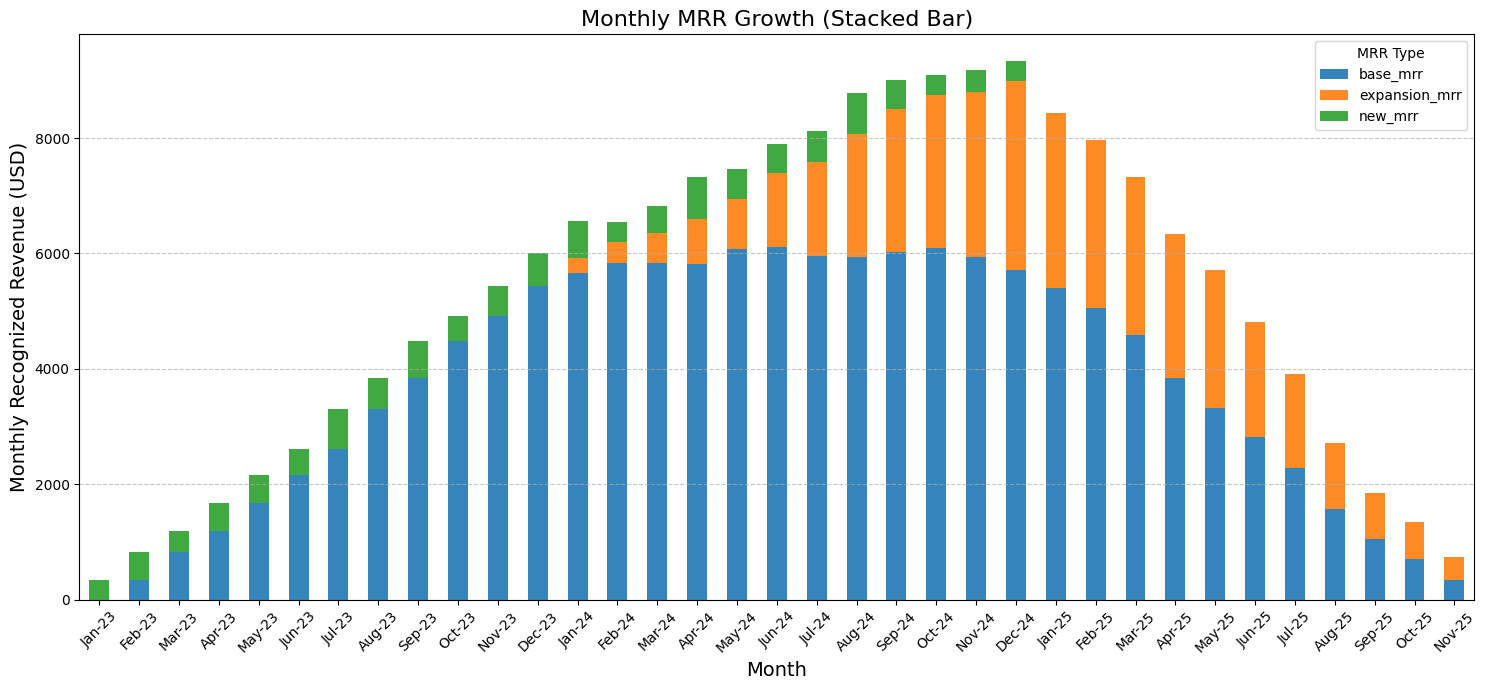

In [5]:
import matplotlib.dates as mdates

# Step 15: Updated plot with formatted dates
fig, ax = plt.subplots(figsize=(15, 7))

# Plot stacked bar chart
monthly_mrr_summary.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    alpha=0.9
)

# Format x-axis
ax.set_title('Monthly MRR Growth (Stacked Bar)', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Monthly Recognized Revenue (USD)', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='MRR Type')

# Set custom x-axis labels to format mmm-yy
new_labels = [dt.strftime('%b-%y') for dt in monthly_mrr_summary.index]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, rotation=45)

# Tight layout
plt.tight_layout()

# Show plot
plt.show()


In [6]:
# Step 16: Identify customers who did not renew

# Step 16a: Create a list of all customers who made a renewal
renewal_clients = df[df['order_type'] == 'renewal']['client_id'].unique()

# Step 16b: Create a list of all customers who made a new order
new_clients = df[df['order_type'] == 'new_order']['client_id'].unique()

# Step 16c: Customers who churned are those who made a new_order but no renewal
churned_clients = set(new_clients) - set(renewal_clients)

print(f"Number of churned customers identified: {len(churned_clients)}")

# Step 17: Create churned MRR events

# Initialize a list to collect churn events
churn_records = []

for client in churned_clients:
    # Find the client's new order transaction
    client_transactions = df[(df['client_id'] == client) & (df['order_type'] == 'new_order')]
    
    if not client_transactions.empty:
        # Take the earliest transaction (in case somehow multiple)
        transaction = client_transactions.iloc[0]
        start_date = transaction['transaction_date']
        monthly_mrr = transaction['amount_usd'] / 12
        
        # Churn happens 12 months after start_date
        churn_month = (pd.to_datetime(start_date) + pd.DateOffset(months=12)).to_period('M').to_timestamp()
        
        churn_records.append({
            'client_id': client,
            'churn_month': churn_month,
            'churned_mrr': monthly_mrr
        })

# Step 18: Create churn DataFrame
df_churn = pd.DataFrame(churn_records)

print("Preview of churned MRR events:")
display(df_churn.head(5))


Number of churned customers identified: 172
Preview of churned MRR events:


,client_id,churn_month,churned_mrr
0,C00136,2025-03-01,80.0
1,C00070,2024-08-01,10.0
2,C00170,2025-06-01,50.0
3,C00203,2025-09-01,80.0
4,C00146,2025-04-01,70.0


In [7]:
# Step 19: Prepare Churned MRR per month

# Create a DataFrame for churned MRR by churn_month
monthly_churned_mrr = df_churn.groupby('churn_month')['churned_mrr'].sum()

# Step 20: Merge churned MRR into the existing monthly_mrr_summary

# First, ensure index alignment
monthly_churned_mrr.index = pd.to_datetime(monthly_churned_mrr.index)

# Add churned_mrr column to the summary
monthly_mrr_summary['churned_mrr'] = monthly_mrr_summary.index.map(monthly_churned_mrr).fillna(0)

# Step 21: Preview updated monthly summary
print("Updated Monthly MRR Summary with Churned MRR:")
display(monthly_mrr_summary.head(5))


Updated Monthly MRR Summary with Churned MRR:


mrr_type,base_mrr,expansion_mrr,new_mrr,churned_mrr
active_month,,,,
2023-01-01,0.0,0.0,340.0,0.0
2023-02-01,340.0,0.0,480.0,0.0
2023-03-01,820.0,0.0,370.0,0.0
2023-04-01,1190.0,0.0,480.0,0.0
2023-05-01,1670.0,0.0,490.0,0.0


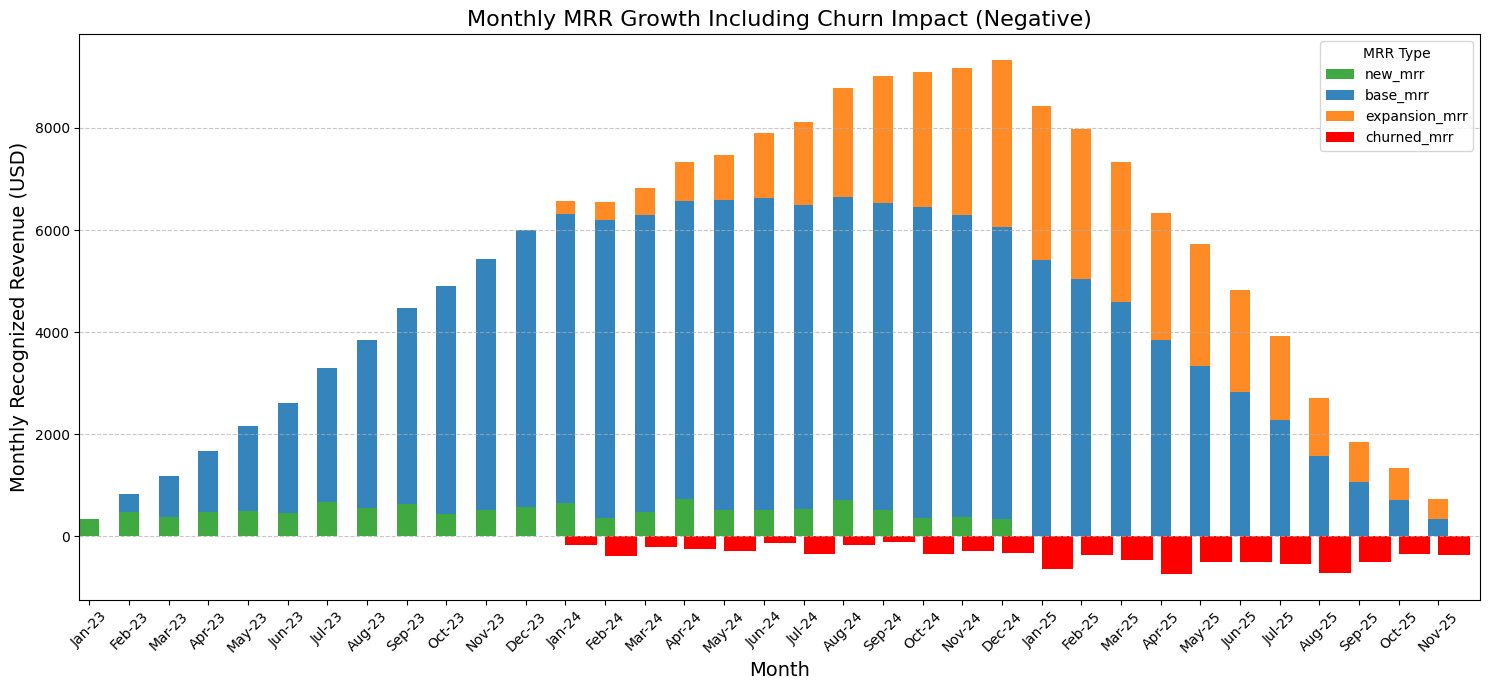

In [8]:
# Step 22: Updated Plot - MRR Components Including Churn as Negative

monthly_mrr_summary['churned_mrr'] = -monthly_mrr_summary['churned_mrr']
fig, ax = plt.subplots(figsize=(15, 7))

# Plot positive MRR components
monthly_mrr_summary[['new_mrr', 'base_mrr', 'expansion_mrr']].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    alpha=0.9,
    color=['#2ca02c', '#1f77b4', '#ff7f0e']
)

# Plot churned MRR (now negative) separately
monthly_mrr_summary['churned_mrr'].plot(
    kind='bar',
    ax=ax,
    color='red',
    position=0,
    width=0.8,
    label='churned_mrr'
)

# Titles and labels
ax.set_title('Monthly MRR Growth Including Churn Impact (Negative)', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Monthly Recognized Revenue (USD)', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='MRR Type')

# Format x-axis labels
new_labels = [dt.strftime('%b-%y') for dt in monthly_mrr_summary.index]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, rotation=45)

plt.tight_layout()
plt.show()


In [9]:
# Step 23: Filter only 2024 data for Quick Ratio calculation
mrr_2024 = monthly_mrr_summary[(monthly_mrr_summary.index >= '2024-01-01') & (monthly_mrr_summary.index <= '2024-12-01')].copy()

# Step 24: Calculate growth and lost MRR
mrr_2024['growth_mrr'] = mrr_2024['new_mrr'] + mrr_2024['expansion_mrr']
mrr_2024['lost_mrr'] = mrr_2024['churned_mrr'].abs()

# Step 25: Calculate Quick Ratio
mrr_2024['quick_ratio'] = mrr_2024['growth_mrr'] / mrr_2024['lost_mrr']

# Step 26: Preview Quick Ratio for 2024
print("Monthly Quick Ratio for 2024:")
display(mrr_2024[['growth_mrr', 'lost_mrr', 'quick_ratio']])


Monthly Quick Ratio for 2024:


mrr_type,growth_mrr,lost_mrr,quick_ratio
active_month,,,
2024-01-01,900.0,180.0,5.000000
2024-02-01,710.0,380.0,1.868421
2024-03-01,990.0,210.0,4.714286
2024-04-01,1510.0,250.0,6.040000
2024-05-01,1390.0,290.0,4.793103
2024-06-01,1780.0,140.0,12.714286
2024-07-01,2170.0,350.0,6.200000
2024-08-01,2840.0,170.0,16.705882
2024-09-01,2990.0,120.0,24.916667


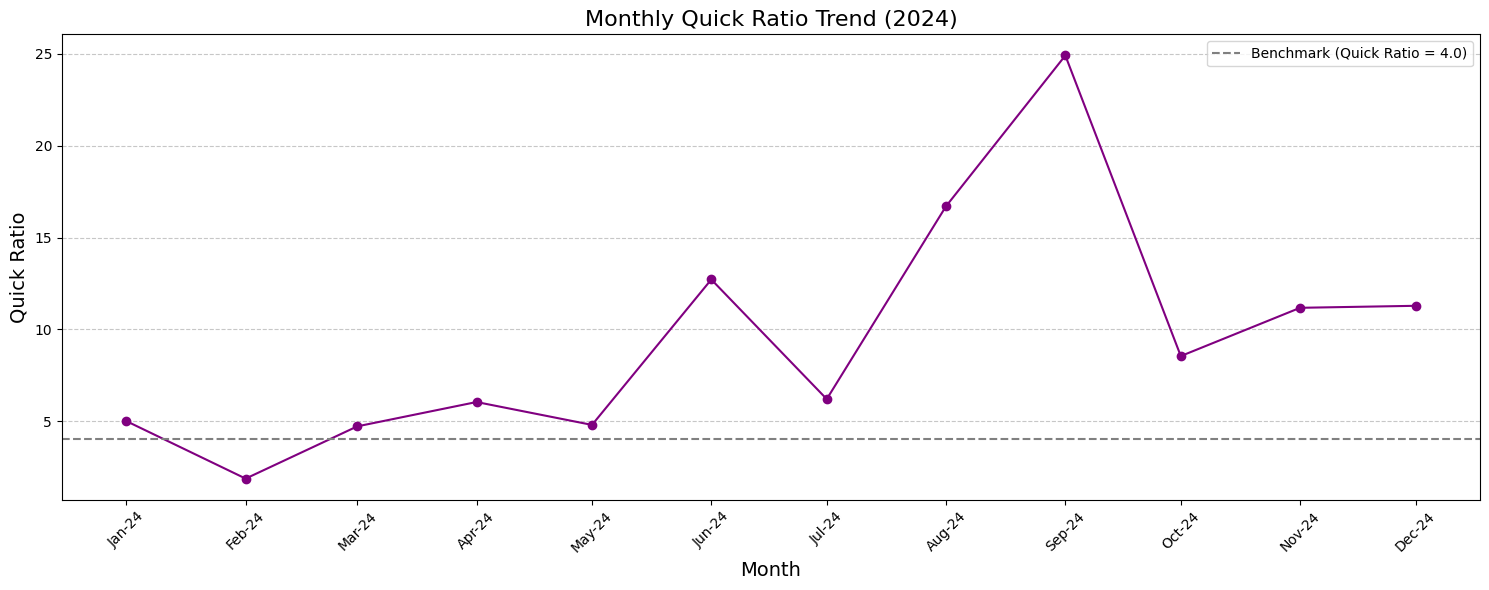

In [10]:
# Step 27: Plot Quick Ratio Trend for 2024

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,6))

# Plot Quick Ratio
ax.plot(mrr_2024.index, mrr_2024['quick_ratio'], marker='o', linestyle='-', color='purple')

# Add benchmark line (e.g., standard healthy SaaS Quick Ratio is 4.0)
ax.axhline(y=4.0, color='gray', linestyle='--', label='Benchmark (Quick Ratio = 4.0)')

# Titles and labels
ax.set_title('Monthly Quick Ratio Trend (2024)', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Quick Ratio', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

# Format x-axis
new_labels = [dt.strftime('%b-%y') for dt in mrr_2024.index]
ax.set_xticks(mrr_2024.index)
ax.set_xticklabels(new_labels, rotation=45)

plt.tight_layout()
plt.show()


In [11]:
# Step Bonus: Recalculate churned_mrr based on full annual subscription value

# Map client_id to their original annual_amount
client_annual_amount = df[df['order_type'] == 'new_order'].set_index('client_id')['amount_usd'].to_dict()

# Create new churn DataFrame with full annual amount lost
churn_records_annual = []

for client in churned_clients:
    if client in client_annual_amount:
        amount_annual = client_annual_amount[client]
        client_transactions = df[(df['client_id'] == client) & (df['order_type'] == 'new_order')]
        if not client_transactions.empty:
            transaction = client_transactions.iloc[0]
            churn_month = (pd.to_datetime(transaction['transaction_date']) + pd.DateOffset(months=12)).to_period('M').to_timestamp()
            
            churn_records_annual.append({
                'client_id': client,
                'churn_month': churn_month,
                'churned_mrr_full': amount_annual
            })

# Create new DataFrame
df_churn_full = pd.DataFrame(churn_records_annual)

# Aggregate by churn month
monthly_churned_full = df_churn_full.groupby('churn_month')['churned_mrr_full'].sum()

# Re-calculate lost_mrr and quick_ratio for 2024
mrr_2024['lost_mrr_full'] = mrr_2024.index.map(monthly_churned_full).fillna(0)

# New Quick Ratio with full annual churn
mrr_2024['quick_ratio_full_churn'] = mrr_2024['growth_mrr'] / mrr_2024['lost_mrr_full']

# Preview
print("Quick Ratio based on Full Annual Churned Amount:")
display(mrr_2024[['growth_mrr', 'lost_mrr_full', 'quick_ratio_full_churn']])


Quick Ratio based on Full Annual Churned Amount:


mrr_type,growth_mrr,lost_mrr_full,quick_ratio_full_churn
active_month,,,
2024-01-01,900.0,2160,0.416667
2024-02-01,710.0,4560,0.155702
2024-03-01,990.0,2520,0.392857
2024-04-01,1510.0,3000,0.503333
2024-05-01,1390.0,3480,0.399425
2024-06-01,1780.0,1680,1.059524
2024-07-01,2170.0,4200,0.516667
2024-08-01,2840.0,2040,1.392157
2024-09-01,2990.0,1440,2.076389


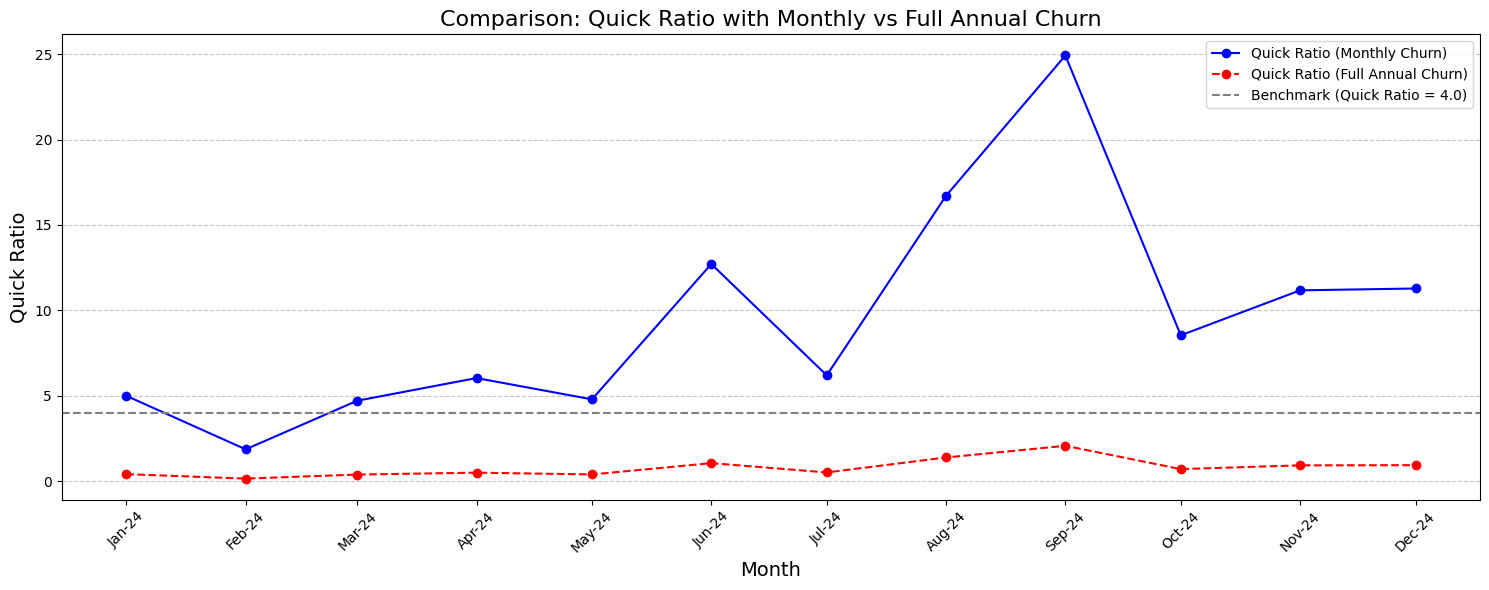

In [12]:
# Step Final: Plot Comparison of Quick Ratios

fig, ax = plt.subplots(figsize=(15,6))

# Plot Normal Quick Ratio
ax.plot(mrr_2024.index, mrr_2024['quick_ratio'], marker='o', linestyle='-', color='blue', label='Quick Ratio (Monthly Churn)')

# Plot Full Annual Churn Quick Ratio
ax.plot(mrr_2024.index, mrr_2024['quick_ratio_full_churn'], marker='o', linestyle='--', color='red', label='Quick Ratio (Full Annual Churn)')

# Add benchmark line (Quick Ratio = 4.0)
ax.axhline(y=4.0, color='gray', linestyle='--', label='Benchmark (Quick Ratio = 4.0)')

# Titles and labels
ax.set_title('Comparison: Quick Ratio with Monthly vs Full Annual Churn', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Quick Ratio', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

# Format x-axis labels
new_labels = [dt.strftime('%b-%y') for dt in mrr_2024.index]
ax.set_xticks(mrr_2024.index)
ax.set_xticklabels(new_labels, rotation=45)

plt.tight_layout()
plt.show()
